# Projekt nr 1 Wyznaczanie otoczki wypukłej
## Norbert Wolniak
## Adam Dyda

# Narzędzie graficzne

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import functools
import math
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()
        
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

# Funkcja zwracająca listę dodanych punktów interaktywnie

In [2]:
def collection_to_points(collection):
    points = []
    for elem in collection:
        for point in elem.points:
            points.append(point)
    return points

# Funkcje pomocnicze 

In [36]:
from functools import cmp_to_key
#Wyznacznik 3 x 3
def det(p, q, r):
    return p[0]*q[1] + q[0]*r[1] + r[0]*p[1] - r[0]*q[1] - p[0]*r[1] - q[0]*p[1]

#Orientacja punktu względem wektora
def orientation(p, q, r, e = 10**(-10)):
    d = det(p,q,r)
    if d > e:
        return 1
    elif d < -e:
        return -1
    else:
        return 0

#Funkcja pomocnicza potrzebna do sortowania ccw
def alpha(p, q, r, e = 10**(-13)):
    d = det(p,q,r)
    if p == q :
        return -1
    elif p == r:
        return 1
    elif d > e:
        return -1
    elif d < -e:
        return 1
    elif -e<d<e:
        return 0

#Sortowanie ccw względem punktu
def sorted_ccw(convex_hull, point, e = 10**(-13)):
    return sorted(convex_hull,key = cmp_to_key(lambda q,r : alpha(point,q,r,e))) 
    
#Odległość dwóch punktów od siebie
def distance(p,minPoint): # bez pierwiastka - niepotrzebny
    q = (p[0]-minPoint[0],p[1]-minPoint[1])
    return q[0]**2 + q[1]**2


# Funkcje pomocnicze : Incremental_Algorithm

In [4]:
#Czy punkt leży wewnątrz zbioru
def lies_inside(convex_hull, point, e):
    n = len(convex_hull)
    if point in convex_hull:
        return False
    for i in range(1, n + 1):
        if orientation(convex_hull[i-1], convex_hull[i%n], point, e) == -1:
            return False
        elif orientation(convex_hull[i-1],convex_hull[i%n], point, e) == 0:
            if (distance(convex_hull[i-1], point) > distance(convex_hull[i-1],convex_hull[i%n])) or (distance(convex_hull[i%n],point) > distance(convex_hull[i-1],convex_hull[i%n])):
                return False
    return True

#Wyznaczanie indeksów punktów leżących na stycznej do zbioru od punktu point
def compute_tangent_points(convex_hull, point, e):
    n = len(convex_hull)
    tangent_points = []
    
    i = 0
    while orientation(point,convex_hull[i%n],convex_hull[(i+1)%n]) <= 0:
        i += 1
    
    while orientation(point, convex_hull[(i-1)%n], convex_hull[i%n]) == 1:
        i -= 1
    
    tangent_points.append(i)
    
    i = 0
    while orientation(point,convex_hull[i%n],convex_hull[(i+1)%n]) >= 1:
        i += 1
    
    while orientation(point,convex_hull[(i-1)%n], convex_hull[i%n]) == -1:
        i -= 1
        
    tangent_points.append(i)
    
    return tangent_points

# Funkcje pomocnicze : Graham_Algorithm 

In [5]:
#Usuwanie punktów współliniowych z pewnym punktem ze zbioru
def delete_collinear(S,minPoint,e):
    i = 2
    while i < len(S):
        d = det(minPoint,S[i-1],S[i])
        if -e<d<e:
            if distance(S[i-1],minPoint) > distance(S[i],minPoint):
                S.pop(i)
            else:
                S.pop(i-1)
        else:
            i+=1
    return S

# Funkcje pomocnicze : Quickhull

In [6]:
def distance_to_line(p, A, B):
    x_diff = B[0] - A[0]
    y_diff = B[1] - A[1]
    num = abs(y_diff*p[0] - x_diff*p[1] + B[0]*A[1] - B[1]*A[0])
    den = math.sqrt(y_diff**2 + x_diff**2)
    return num / den

# Funkcje pomocnicze : Chan_Algorithm

In [7]:
def min_angle(a, b, c, epsilon=10**-12):
    o = orientation(a,b,c)
    if o == 0:
        if dist(a, b) > dist(a, c):
            return b
        else:
            return c
    if o == -1:
        return b
    return c


def split(P,m):
    import random
    import copy
    return list((P[i:i+m] for i in range(0, len(P), m)))


def jarvis_next_point(p1,hull):
    return functools.reduce(lambda a, b: min_angle(p1, a, b), hull)

# Algorytmy :

## 1. Incremental Algorithm

In [8]:
def incremental_algorithm(S, e = 10**(-13)):
    if len(S)<=2:
        return S
    
    #Add 3 first points of set S to convex hull
    convex_hull = sorted_ccw([S[0],S[1],S[2]], S[0], e)
    
    #Add point if it does not lie inside convex_hull
    for i in range(3,len(S)):
        if not lies_inside(convex_hull, S[i], e):
            #Compute tangent points to S[i]
            computed_tangent_points = compute_tangent_points(convex_hull, S[i], e)
            
            n = len(convex_hull)
            j = computed_tangent_points[0]
            new_convex_hull = [convex_hull[j%n]]
            
            if computed_tangent_points[1] < 0:
                computed_tangent_points[1] = n + computed_tangent_points[1]
            
            while j%n != computed_tangent_points[1]:
                j += 1
                new_convex_hull.append(convex_hull[j%n])
                
            new_convex_hull.append(S[i])
            convex_hull = new_convex_hull
    
    return convex_hull
    

## 2. Upper and lower hulls Algorithm

In [9]:
def upper_lower_algorithm(S):
    #Sort points lexicographically
    points = sorted(S, key = lambda point : (point[0],point[1]))
    
    #Create a starting upper chain from first 2 points
    upper_chain = [points[0],points[1]]
    n = len(upper_chain)
    
    #For the rest of the points while last three are not cw oriented
    for i in range(2, len(points)):
        upper_chain.append(points[i])
        n += 1
        while n > 2 and orientation(upper_chain[-3],upper_chain[-2],upper_chain[-1]) >= 0:
            #Remove the middle one
            upper_chain.pop(-2)
            n -= 1
    
    #Create a starting lower convex hull from last 2 points
    lower_chain = [points[len(points)-1],points[len(points)-2]]
    n = len(lower_chain)
    
    #For the rest of the points while last three are not cw oriented
    for i in range(len(points)-3 , -1, -1):
        lower_chain.append(points[i])
        n += 1
        while n > 2 and orientation(lower_chain[-3], lower_chain[-2], lower_chain[-1]) >= 0:
            #Remove the middle one
            lower_chain.pop(-2)
            n -= 1
    
    # Return convex hull consisting of upper and lower chains
    return upper_chain + lower_chain[1:(len(lower_chain)-1)]

## 3. Graham Algorithm

In [10]:
def graham_algorithm(S,e = 10**(-13)):
    #Minimum point lexicographically
    minPoint = min(S, key = lambda point : (point[1],point[0]))
    #Sort points (starting one minPoint)
    S = sorted_ccw(S,minPoint,e)
    #Delete collinear points to minPoint
    S = delete_collinear(S, minPoint, e)
    
    if len(S) <= 3:
        return S
    
    stack = [S[0],S[1],S[2]]
    i = 3
    while i < len(S):
        d = det(stack[-2],stack[-1],S[i])
        if d > e:
            stack.append(S[i])
            i += 1
        elif d > -e and d < e:
            stack.pop()
            stack.append(S[i])
            i += 1
        else:
            stack.pop()
    return stack

## 4. Jarvis Algorithm

In [11]:
def jarvis_algorithm(S, e = 10**(-10)):
    p = min(S, key = lambda point : (point[1],point[0]))
    stack = []
    flag = True
    i = 0
    while flag:     
        stack.append(p)
        q = S[0]
        for j in range(len(S)):
            d = det(stack[i],q,S[j])
            if p == q:
                q = S[j]
            elif -e<d<e:
                if distance(stack[i],q) < distance(stack[i],S[j]):
                    q = S[j]
            elif d < -e:
                q = S[j]
        i+=1
        if q == stack[0]:
            flag = False
        p = q
        
    return stack

## 5. Divide and Conquer Algorithm

In [12]:
import statistics

def divide_and_conquer_algorithm(S,k):
    #If size of set is less or equal to some const k
    if len(S) <= k:
        return graham_algorithm(S)
    
    #Sort points : x coordinate (only once)
    points = sorted(S, key = lambda point : (point[0],point[1]))
    
    #Median index
    median_index = points.index(statistics.median_low(points))
    
    #Left side
    A = divide_and_conquer(points[0:median_index], k)
    #Right side
    B = divide_and_conquer(points[median_index:], k)
    
    #Return merged both sides
    return merge_convex_hulls(A,B)
    
def divide_and_conquer(points, k):
    #If size of set is less or equal to some const k
    if len(points) <= k:
        return graham_algorithm(points)
    
    #Median index
    median_index = points.index(statistics.median_low(points))
    
    #Left side
    A = divide_and_conquer(points[0:median_index], k)
    #Right side
    B = divide_and_conquer(points[median_index:], k)
    
    #Return merged both sides
    return merge_convex_hulls(A,B)
    
def merge_convex_hulls(A,B):
    #Sort left side ccw (point with max x coordinate is starting one)
    A = sorted_ccw(A,max(A, key = lambda point : (point[0],point[1])))
    #Sort right side ccw (point with min x coordinate is starting one)
    B = sorted_ccw(B,min(B, key = lambda point : (point[0],point[1])))
    
    #Right most A
    n = len(A)
    i = 0
    
    #Left most B
    m = len(B)
    j = 0
    
    done = False
    while not done:
        done = True
        while m > 1 and j > -(m - 1) and orientation(A[i],B[j%m],B[(j-1)%m]) >= 0:
            j -= 1
        while n > 1 and i < n - 1 and orientation(A[(i+1)],A[i],B[j%m]) >= 0:
            i += 1
            done = False
    
    #Tuple of indexes of upper tangent (A[i%n],B[j%m]) 
    upper_tangent = (i,j%m)
    
    #Right most A
    i = 0
    #Left most B
    j = 0
    
    done = False
    while not done:
        done = True
        while m > 1 and j < m - 1  and orientation(A[i%n],B[j],B[j+1]) <= 0:
            j += 1
        while n > 1 and i > -(n-1) and orientation(A[(i-1)%n],A[i%n],B[j]) <= 0:
            i -= 1
            done = False
            
    #Tuple of indexes of lower tangent (A[i%n],B[j])
    lower_tangent = (i%n,j)
 
    #Merge left and right convex hulls due to upper and lower tangent
    i = upper_tangent[0]
    convex_hull = [A[i]]
    
    while i%n != lower_tangent[0]:
        i += 1
        convex_hull.append(A[i%n])
    
    i = lower_tangent[1]
    convex_hull.append(B[i%m])
    
    while i%m != upper_tangent[1]:
        i += 1
        convex_hull.append(B[i%m])
        
    return convex_hull

## 6. QuickHull Algorithm

In [13]:
def quickhull_step(A,B,S):
    if not S:
        return 
    if len(S) == 1:
        return [S[0]]
    C = max(S,key = lambda x:distance_to_line(x,A,B))
    S1 = []
    S2 = []
    res = []
    for p in S:
        if orientation(A,C,p) == -1:
            S1.append(p)
        if orientation(C,B,p) == -1:
            S2.append(p)

    res1 = quickhull_step(A,C,S1)
    if res1:
        res.extend(res1)
    res.append(C)
    res2 = quickhull_step(C,B,S2)
    if res2:
        res.extend(res2)

    return res


def quickhull(S):
    res = []
    A = min(S,key = lambda x:x[0])
    B = max(S, key = lambda x:x[0])
    S1 = []
    S2 = []
    for p in S:
        if orientation(A,B,p) == -1:
            S1.append(p)
        if orientation(A,B,p) == 1:
            S2.append(p)
    res.append(A)
    res1 = quickhull_step(A,B,S1)
    if res1:
        res.extend(res1)
    res.append(B)
    res2 = quickhull_step(B,A,S2)
    if res2:
        res.extend(res2)
    return res




## 7. Chan's Algorithm

In [14]:
def chan_algorithm(P):
    p = min(P,key = lambda x:(x[1],x[0]))
    t = 1
    while(True):
        p1 = p
        m = 2**(2**t)
        C = []
        C.append(p)
        Q = split(P,m)
        hulls = []
        for k in range(len(Q)):
            hulls.append(graham_algorithm(Q[k]))
        for i in range(1,m):
            q = []
            for k in range(len(hulls)):
                q.append(jarvis_next_point(p1,hulls[k]))
            p2 = jarvis_next_point(p1,q)
            
            if p2 == p:
                return C
            else:
                p1 = p2
                C.append(p2)
        t = t+1
               


# Funkcje wizualizujące algorytmy :

## Funkcja pomocnicza wyznaczająca krawędzie otoczki

In [ ]:
def compute_convex_hull_lines(convex_hull):
    n = len(convex_hull)
    convex_hull_lines = []
    for i in range(1, n + 1):
        convex_hull_lines.append([convex_hull[i-1],convex_hull[i%n]])
    return convex_hull_lines

## 1. Incremental Algorithm visualisation

In [ ]:
def plot_incremental_algorithm(S, e = 10**(-13)):
    if len(S)<=2:
        return S
    
    
    
    #Add 3 first points of set S to convex hull
    convex_hull = sorted_ccw([S[0],S[1],S[2]],S[0], e)
    convex_hull_lines = compute_convex_hull_lines(convex_hull)
    plot = Plot(scenes = [Scene(points = [PointsCollection(S.copy(),color="blue"),
                                          PointsCollection(convex_hull.copy(),color="green")],
                               lines = [LinesCollection(convex_hull_lines.copy(),color="green")])])
    
    
    #Add point 
    for i in range(3,len(S)):
        if not lies_inside(convex_hull, S[i], e):
            computed_tangent_points = compute_tangent_points(convex_hull, S[i], e)
            
            tangent_lines = [[convex_hull[computed_tangent_points[0]],S[i]],[convex_hull[computed_tangent_points[1]],S[i]]]
            plot.add_scene(Scene(points = [PointsCollection(S.copy(),color="blue"),
                                       PointsCollection(convex_hull.copy(),color="green"),
                                       PointsCollection([S[i]],color="red")],
                                lines = [LinesCollection(convex_hull_lines.copy(),color = "green"),
                                        LinesCollection(tangent_lines.copy(),color="red")]))
            
            
           
            n = len(convex_hull)
            
            if computed_tangent_points[1] < 0:
                computed_tangent_points[1] = n + computed_tangent_points[1]
                
            j = computed_tangent_points[0]
            new_convex_hull = [convex_hull[j%n]]
            
            while j%n != computed_tangent_points[1]:
                j += 1
                new_convex_hull.append(convex_hull[j%n])
                
            new_convex_hull.append(S[i])
            convex_hull = new_convex_hull
            
            convex_hull_lines = compute_convex_hull_lines(convex_hull)
            
            plot.add_scene(Scene(points = [PointsCollection(S.copy(),color="blue"),
                                       PointsCollection(convex_hull.copy(),color="green")],
                                lines = [LinesCollection(convex_hull_lines.copy(),color = "green")]))

     
    plot.add_scene(Scene(points = [PointsCollection(S.copy(), color = "blue"),
                                   PointsCollection(convex_hull.copy(), color = "green")],
                         lines = [LinesCollection(convex_hull_lines.copy(),color = "green")]))
    
    return plot

## 2. Upper and lower hulls Algorithm visualisation

In [ ]:
def plot_upper_lower_algorithm(S):
    points = sorted(S, key = lambda point : (point[0],point[1]))
   
    upper_chain = [points[0],points[1]]
    n = len(upper_chain)
    
    convex_hull_lines = [[points[0],points[1]]]
    plot = Plot(scenes = [Scene(points = [PointsCollection(S.copy(),color="blue"),
                                          PointsCollection(upper_chain.copy(),color="green")],
                                lines = [LinesCollection(convex_hull_lines.copy(),color = "green")])])
    
    tmp_lines = []
    
    for i in range(2, len(points)):
        upper_chain.append(points[i])
        n += 1
        tmp_lines.append([upper_chain[-2],upper_chain[-1]])
        plot.add_scene(Scene(points = [PointsCollection(S.copy(),color="blue"),
                                       PointsCollection(upper_chain.copy(),color="green"),
                                       PointsCollection([upper_chain[-1]], color = "red")],
                             lines = [LinesCollection(convex_hull_lines.copy(),color = "green"),
                                      LinesCollection(tmp_lines.copy(), color = "red")]))
        tmp_lines.pop()
        while n > 2 and orientation(upper_chain[-3],upper_chain[-2],upper_chain[-1]) >= 0:
            upper_chain.pop(-2)
            n -= 1
            convex_hull_lines.pop()
            tmp_lines.append([upper_chain[-2],upper_chain[-1]])
            plot.add_scene(Scene(points = [PointsCollection(S.copy(),color="blue"),
                                       PointsCollection(upper_chain.copy(),color="green"),
                                       PointsCollection([upper_chain[-1]], color = "red")],
                             lines = [LinesCollection(convex_hull_lines.copy(),color = "green"),
                                      LinesCollection(tmp_lines.copy(), color = "red")]))
            tmp_lines.pop()
            
        convex_hull_lines.append([upper_chain[-2],upper_chain[-1]])
        plot.add_scene(Scene(points = [PointsCollection(S.copy(),color="blue"),
                                       PointsCollection(upper_chain.copy(),color="green"),
                                       PointsCollection([upper_chain[-1]], color = "red")],
                             lines = [LinesCollection(convex_hull_lines.copy(),color = "green"),
                                      LinesCollection(tmp_lines.copy(), color = "red")]))
        
    
    lower_chain = [points[len(points)-1],points[len(points)-2]]
    n = len(lower_chain)
    
    convex_hull_lines.append([lower_chain[-2],lower_chain[-1]])
    
    for i in range(len(points)-3 , -1, -1):
        lower_chain.append(points[i])
        n += 1
        tmp_lines.append([lower_chain[-2],lower_chain[-1]])
        plot.add_scene(Scene(points = [PointsCollection(S.copy(),color="blue"),
                                       PointsCollection(upper_chain.copy(),color="green"),
                                       PointsCollection(lower_chain.copy(), color = "green"),
                                       PointsCollection([lower_chain[-1]],color="red")],
                             lines = [LinesCollection(convex_hull_lines.copy(),color = "green"),
                                      LinesCollection(tmp_lines.copy(), color = "red")]))
        
        tmp_lines.pop()
        while n > 2 and orientation(lower_chain[-3], lower_chain[-2], lower_chain[-1]) >= 0:
            lower_chain.pop(-2)
            n -= 1
            convex_hull_lines.pop()
            tmp_lines.append([lower_chain[-2],lower_chain[-1]])
            plot.add_scene(Scene(points = [PointsCollection(S.copy(),color="blue"),
                                           PointsCollection(upper_chain.copy(),color="green"),
                                           PointsCollection(lower_chain.copy(), color = "green"),
                                           PointsCollection([lower_chain[-1]],color="red")],
                                lines = [LinesCollection(convex_hull_lines.copy(),color = "green"),
                                      LinesCollection(tmp_lines.copy(), color = "red")]))
            tmp_lines.pop()
        
        convex_hull_lines.append([lower_chain[-2],lower_chain[-1]])
        plot.add_scene(Scene(points = [PointsCollection(S.copy(),color="blue"),
                                           PointsCollection(upper_chain.copy(),color="green"),
                                           PointsCollection(lower_chain.copy(), color = "green"),
                                           PointsCollection([lower_chain[-1]],color="red")],
                                lines = [LinesCollection(convex_hull_lines.copy(),color = "green"),
                                      LinesCollection(tmp_lines.copy(), color = "red")]))
            
    plot.add_scene(Scene(points = [PointsCollection(S.copy(),color="blue"),
                                           PointsCollection(upper_chain.copy(),color="green"),
                                           PointsCollection(lower_chain.copy(), color = "green")],
                                lines = [LinesCollection(convex_hull_lines.copy(),color = "green")]))
        
    
    return plot

## 3. Graham Algorithm visualisation

In [ ]:
def plot_graham_algorithm(S,e = 10**(-13)):
    
    plot = Plot(scenes = [Scene(points = [PointsCollection(S,color="blue")])])
    pointsBlue = S.copy()
    pointsGreen = []
    pointsRed = []
    linesRed = []
    linesGreen = []

    minPoint = min(S, key = lambda point : (point[1], point[0]))
    S = sorted(S,key = cmp_to_key(lambda q,r : alpha(minPoint,q,r,e)))
    S = delete_collinear(S, minPoint, e)
    
    stack = [S[0],S[1],S[2]]
    i = 3
    
    pointsGreen.append(S[0])
    pointsGreen.append(S[1])
    pointsGreen.append(S[2])
    linesGreen.append([pointsGreen[0],pointsGreen[1]])
    linesGreen.append([pointsGreen[1],pointsGreen[2]])
    plot.add_scene(Scene(points = [PointsCollection(pointsBlue.copy(),color="blue"),
                                   PointsCollection(pointsGreen.copy(),color="green"),
                                   PointsCollection(pointsRed.copy(),color="red")],
                         lines = [LinesCollection(linesRed.copy(),color="red"),
                                  LinesCollection(linesGreen.copy(),color="green")]))
    

    
    while i < len(S):
        d = det( stack[-2], stack[-1], S[i])
        
        pointsRed.append(S[i])
        linesRed.append([pointsGreen[-1],pointsRed[-1]])
        plot.add_scene(Scene(points = [PointsCollection(pointsBlue.copy(),color="blue"),
                                       PointsCollection(pointsGreen.copy(),color="green"),
                                       PointsCollection(pointsRed.copy(),color="red")],
                             lines = [LinesCollection(linesRed.copy(),color="red"),
                                      LinesCollection(linesGreen.copy(),color="green")]))
        pointsRed.pop()
        linesRed.pop()
        if d > e:
            stack.append(S[i])
        
            pointsGreen.append(S[i])
            linesGreen.append([pointsGreen[-2],pointsGreen[-1]])
            plot.add_scene(Scene(points = [PointsCollection(pointsBlue.copy(),color="blue"),
                                           PointsCollection(pointsGreen.copy(),color="green"),
                                           PointsCollection(pointsRed.copy(),color="red")],
                                 lines = [LinesCollection(linesRed.copy(),color="red"),
                                          LinesCollection(linesGreen.copy(),color="green")]))
            i += 1
        elif d > -e and d < e:
            stack.pop()
            stack.append(S[i])

            pointsGreen.pop()
            pointsGreen.append(S[i])
            
            linesGreen.pop()
            linesGreen.append([pointsGreen[-2],pointsGreen[-1]])
            
            plot.add_scene(Scene(points = [PointsCollection(pointsBlue.copy(),color="blue"),
                                           PointsCollection(pointsGreen.copy(),color="green"),
                                           PointsCollection(pointsRed.copy(),color="red")],
                                 lines = [LinesCollection(linesRed.copy(),color="red"),
                                          LinesCollection(linesGreen.copy(),color="green")]))
            i += 1
        else:
            stack.pop()
     
            pointsGreen.pop()
            linesGreen.pop()
            plot.add_scene(Scene(points = [PointsCollection(pointsBlue.copy(),color="blue"),
                                           PointsCollection(pointsGreen.copy(),color="green"),
                                           PointsCollection(pointsRed.copy(),color="red")],
                                 lines = [LinesCollection(linesRed.copy(),color="red"),
                                          LinesCollection(linesGreen.copy(),color="green")]))
    
    linesGreen.append([pointsGreen[-1],pointsGreen[0]])
    plot.add_scene(Scene(points = [PointsCollection(pointsBlue.copy(),color="blue"),
                                   PointsCollection(pointsGreen.copy(),color="green"),
                                   PointsCollection(pointsRed.copy(),color="red")],
                         lines = [LinesCollection(linesRed.copy(),color="red"),
                                  LinesCollection(linesGreen.copy(),color="green")]))
    return plot


## 4. Jarvis Algorithm visualisation

In [ ]:
def plot_jarvis_algorithm(S, e = 10**(-10)):
    plot = Plot(scenes = [Scene(points = [PointsCollection(S,color="blue")])])
    pointsBlue = S.copy()
    pointsGreen = []
    pointsPurple = []
    pointsRed = []
    linesRed = []
    linesGreen = []
    linesPurple = []
    
    p = min(S, key = lambda point : (point[1], point[0]))
    stack = []
    i = 0
    flag = True
    while flag:
        
        stack.append(p)
        
        pointsGreen.append(p)
        plot.add_scene(Scene(points = [PointsCollection(pointsBlue.copy(),color="blue"),
                                       PointsCollection(pointsGreen.copy(),color="green"),
                                       PointsCollection(pointsPurple.copy(),color="pink"),
                                       PointsCollection(pointsRed.copy(),color="red")],
                             lines  = [LinesCollection(linesRed.copy(),color="red"),
                                       LinesCollection(linesPurple.copy(),color="pink"),
                                       LinesCollection(linesGreen.copy(),color="green")]))
        
        q = S[0]
        pointsPurple.append(q)
        linesPurple.append([pointsGreen[-1],pointsPurple[-1]])
        for j in range(len(S)):
            
            pointsRed.append(S[j])
            plot.add_scene(Scene(points = [PointsCollection(pointsBlue.copy(),color="blue"),
                                           PointsCollection(pointsGreen.copy(),color="green"),
                                           PointsCollection(pointsPurple.copy(),color="pink"),
                                           PointsCollection(pointsRed.copy(),color="red")],
                                 lines  = [LinesCollection(linesRed.copy(),color="red"),
                                           LinesCollection(linesPurple.copy(),color="pink"),
                                           LinesCollection(linesGreen.copy(),color="green")]))
            pointsRed.pop()
            d = det(stack[i],q,S[j])

            if q == p:
                q = S[j]

            elif -e < d < e:
                if distance(stack[i],q) < distance(stack[i],S[j]):
                    q = S[j]

            elif d < -e:
                q = S[j]
                pointsPurple.pop()
                pointsPurple.append(q)
                linesPurple.pop()
                linesPurple.append([pointsGreen[-1],q])
                plot.add_scene(Scene(points = [PointsCollection(pointsBlue.copy(),color="blue"),
                                               PointsCollection(pointsGreen.copy(),color="green"),
                                               PointsCollection(pointsPurple.copy(),color="pink"),
                                               PointsCollection(pointsRed.copy(),color="red")],
                                     lines  = [LinesCollection(linesRed.copy(),color="red"),
                                               LinesCollection(linesPurple.copy(),color="pink"),
                                               LinesCollection(linesGreen.copy(),color="green")]))

        pointsPurple.pop()
        linesPurple.pop()
        pointsGreen.append(q)
        linesGreen.append([pointsGreen[-2],pointsGreen[-1]])
        plot.add_scene(Scene(points = [PointsCollection(pointsBlue.copy(),color="blue"),
                                       PointsCollection(pointsGreen.copy(),color="green"),
                                       PointsCollection(pointsPurple.copy(),color="pink"),
                                       PointsCollection(pointsRed.copy(),color="red")],
                             lines  = [LinesCollection(linesRed.copy(),color="red"),
                                       LinesCollection(linesPurple.copy(),color="pink"),
                                       LinesCollection(linesGreen.copy(),color="green")]))
        
        i += 1
        if q == stack[0]:
            flag = False
            
        p = q
    return plot

## 5. Divide and Conquer Algorithm visualisation

In [ ]:
def plot_divide_and_conquer_algorithm(S,k):
    convex_hull = []
    convex_hull_lines = []
    plot = Plot(scenes = [Scene(points = [PointsCollection(S.copy(),color="blue"),
                                          PointsCollection(convex_hull.copy(),color="green")],
                               lines = [LinesCollection(convex_hull_lines.copy(),color="green")])])
    #If size of set is less or equal to some const k
    if len(S) <= k:
        convex_hull = graham_algorithm(S)
        convex_hull_lines = compute_convex_hull_lines(convex_hull)
        plot.add_scene(Scene(points = [PointsCollection(S.copy(),color="blue"),
                                       PointsCollection(convex_hull.copy(),color="green")],
                                lines = [LinesCollection(convex_hull_lines.copy(),color = "green")]))
        return plot
    
    
    
    #Sort points : x coordinate (only once)
    points = sorted(S, key = lambda point : (point[0],point[1]))
    
    #Median index
    median_index = points.index(statistics.median_low(points))
    #Left side
    A = plot_divide_and_conquer(points[0:median_index], k, plot, S)
    #Right side
    B = plot_divide_and_conquer(points[median_index:], k, plot, S)
    
    #Return merged both sides
    convex_hull = plot_merge_convex_hulls(A,B, plot, S)
    return plot
    
def plot_divide_and_conquer(points, k, plot, S):
    #If size of set is less or equal to some const k
    if len(points) <= k:
        return graham_algorithm(points)
    
    #Median index
    median_index = points.index(statistics.median_low(points))
    
    #Left side
    A = plot_divide_and_conquer(points[0:median_index], k, plot, S)
    #Right side
    B = plot_divide_and_conquer(points[median_index:], k, plot, S)
    
    #Return merged both sides
    return plot_merge_convex_hulls(A,B, plot, S)
    
def plot_merge_convex_hulls(A,B, plot, S):
    #Sort left side ccw (point with max x coordinate is starting one)
    A = sorted_ccw(A,max(A, key = lambda point : (point[0],point[1])))
    #Sort right side ccw (point with min x coordinate is starting one)
    B = sorted_ccw(B,min(B, key = lambda point : (point[0],point[1])))
    
    
    
    
    A_lines = compute_convex_hull_lines(A)
    B_lines = compute_convex_hull_lines(B)
    
    plot.add_scene(Scene(points = [PointsCollection(S.copy(),color="blue"),
                                   PointsCollection(A.copy(),color="cyan"),
                                   PointsCollection(B.copy(),color="magenta")],
                                lines = [LinesCollection(A_lines.copy(),color = "cyan"),
                                        LinesCollection(B_lines.copy(),color = "magenta")]))
    
    #Right most A
    n = len(A)
    i = 0
    
    #Left most B
    m = len(B)
    j = 0
    
    upper_tangent_line = [[A[i],B[j]]]
    plot.add_scene(Scene(points = [PointsCollection(S.copy(),color="blue"),
                               PointsCollection(A.copy(),color="cyan"),
                               PointsCollection(B.copy(),color="magenta")],
                            lines = [LinesCollection(A_lines.copy(),color = "cyan"),
                                    LinesCollection(B_lines.copy(),color = "magenta"),
                                    LinesCollection(upper_tangent_line.copy(),color="red")]))

    done = False
    while not done:
        done = True
        
        
        while m > 1 and j > -(m - 1) and orientation(A[i],B[j%m],B[(j-1)%m]) >= 0:
            j -= 1
            upper_tangent_line = [[A[i],B[j%m]]]
            plot.add_scene(Scene(points = [PointsCollection(S.copy(),color="blue"),
                                   PointsCollection(A.copy(),color="cyan"),
                                   PointsCollection(B.copy(),color="magenta")],
                                lines = [LinesCollection(A_lines.copy(),color = "cyan"),
                                        LinesCollection(B_lines.copy(),color = "magenta"),
                                        LinesCollection(upper_tangent_line.copy(),color="red")]))
            
        while n > 1 and i < n - 1 and orientation(A[(i+1)],A[i],B[j%m]) >= 0:
            i += 1
            done = False
            upper_tangent_line = [[A[i%n],B[j%m]]]
            plot.add_scene(Scene(points = [PointsCollection(S.copy(),color="blue"),
                                   PointsCollection(A.copy(),color="cyan"),
                                   PointsCollection(B.copy(),color="magenta")],
                                lines = [LinesCollection(A_lines.copy(),color = "cyan"),
                                        LinesCollection(B_lines.copy(),color = "magenta"),
                                        LinesCollection(upper_tangent_line.copy(),color="red")]))
        
        
        
    upper_tangent_line = [[A[i],B[j%m]]]
    
    plot.add_scene(Scene(points = [PointsCollection(S.copy(),color="blue"),
                           PointsCollection(A.copy(),color="cyan"),
                           PointsCollection(B.copy(),color="magenta")],
                        lines = [LinesCollection(A_lines.copy(),color = "cyan"),
                                LinesCollection(B_lines.copy(),color = "magenta"),
                                LinesCollection(upper_tangent_line.copy(),color="green")]))
    
    #Tuple of indexes of upper tangent (A[i],B[j%m]) 
    upper_tangent = (i,j%m)
    
    #Right most A
    i = 0
    #Left most B
    j = 0
    
    lower_tangent_line = [[A[i],B[j]]]
    plot.add_scene(Scene(points = [PointsCollection(S.copy(),color="blue"),
                           PointsCollection(A.copy(),color="cyan"),
                           PointsCollection(B.copy(),color="magenta")],
                        lines = [LinesCollection(A_lines.copy(),color = "cyan"),
                                LinesCollection(B_lines.copy(),color = "magenta"),
                                LinesCollection(upper_tangent_line.copy(),color="green"),
                                LinesCollection(lower_tangent_line.copy(),color="red")]))
    
    done = False
    
    
    
    while not done:
        done = True
        while m > 1 and j < m - 1  and orientation(A[i%n],B[j],B[(j+1)]) <= 0:
            j += 1
            lower_tangent_line = [[A[i%n],B[j%m]]]
            plot.add_scene(Scene(points = [PointsCollection(S.copy(),color="blue"),
                                   PointsCollection(A.copy(),color="cyan"),
                                   PointsCollection(B.copy(),color="magenta")],
                                lines = [LinesCollection(A_lines.copy(),color = "cyan"),
                                        LinesCollection(B_lines.copy(),color = "magenta"),
                                        LinesCollection(upper_tangent_line.copy(),color="green"),
                                        LinesCollection(lower_tangent_line.copy(),color="red")]))
        
        while n > 1 and i > -(n-1) and orientation(A[(i-1)%n],A[i%n],B[j]) <= 0:
            i -= 1
            done = False
            lower_tangent_line = [[A[i%n],B[j%m]]]
            plot.add_scene(Scene(points = [PointsCollection(S.copy(),color="blue"),
                                   PointsCollection(A.copy(),color="cyan"),
                                   PointsCollection(B.copy(),color="magenta")],
                                lines = [LinesCollection(A_lines.copy(),color = "cyan"),
                                        LinesCollection(B_lines.copy(),color = "magenta"),
                                        LinesCollection(upper_tangent_line.copy(),color="green"),
                                        LinesCollection(lower_tangent_line.copy(),color="red")]))
       
        
    lower_tangent_line = [[A[i%n],B[j]]]
    plot.add_scene(Scene(points = [PointsCollection(S.copy(),color="blue"),
                           PointsCollection(A.copy(),color="cyan"),
                           PointsCollection(B.copy(),color="magenta")],
                        lines = [LinesCollection(A_lines.copy(),color = "cyan"),
                                LinesCollection(B_lines.copy(),color = "magenta"),
                                LinesCollection(upper_tangent_line.copy(),color="green"),
                                LinesCollection(lower_tangent_line.copy(),color="green")]))
    
    
    #Tuple of indexes of lower tangent (A[i%n],B[j%m])
    lower_tangent = (i%n,j)
 
    #Merge left and right convex hulls due to upper and lower tangent
    i = upper_tangent[0]
    convex_hull = [A[i]]
    
    while i%n != lower_tangent[0]:
        i += 1
        convex_hull.append(A[i%n])
    
    i = lower_tangent[1]
    convex_hull.append(B[i%m])
    
    while i%m != upper_tangent[1]:
        i += 1
        convex_hull.append(B[i%m])
    
    convex_hull_lines = compute_convex_hull_lines(convex_hull)
    plot.add_scene(Scene(points = [PointsCollection(S.copy(),color="blue"),
                                   PointsCollection(convex_hull.copy(),color="green")],
                                lines = [LinesCollection(convex_hull_lines.copy(),color = "green")]))
    
    return convex_hull



## 6. QuickHull Algorithm visualisation

In [28]:
def plot_quickhull_step(points,A,B,S,plot):
    if not S:
        return 
    if len(S) == 1:
        return [S[0]]
    C = max(S,key = lambda x:distance_to_line(x,A,B))
    plot.add_scene(Scene(points = [PointsCollection(points.copy(), color = "blue"),
                                   PointsCollection([C], color = "green")],
                         lines = [LinesCollection([[A,B],[A,C],[B,C]],color = "green")]))
    S1 = []
    S2 = []
    res = []
    for p in S:
        if orientation(A,C,p) == -1:
            S1.append(p)
        if orientation(C,B,p) == -1:
            S2.append(p)
    
    res1 = plot_quickhull_step(points,A,C,S1,plot)
    if res1:
        res.extend(res1)
    res.append(C)
    res2 = plot_quickhull_step(points,C,B,S2,plot)
    if res2:
        res.extend(res2)
    
    return res


def plot_quickhull(S):
    
    plot = Plot(scenes = [Scene(points = [PointsCollection(S.copy(),color="blue")])])
    
    res = []
    A = min(S,key = lambda x:x[0])
    B = max(S, key = lambda x:x[0])
    S1 = []
    S2 = []
    for p in S:
        if orientation(A,B,p) == -1:
            S1.append(p)
        if orientation(A,B,p) == 1:
            S2.append(p)
    res.append(A)
    res1 = plot_quickhull_step(S,A,B,S1,plot)
    if res1:
        res.extend(res1)
    res.append(B)
    res2 = plot_quickhull_step(S,B,A,S2,plot)
    if res2:
        res.extend(res2)
        
    plot.add_scene(Scene(points = [PointsCollection(S.copy(), color = "blue"),
                                   PointsCollection(res.copy(), color = "green")],
                         lines = [LinesCollection(compute_convex_hull_lines(res),color = "green")]))
    return plot

## 7. Chan's Algorithm visualisation

In [ ]:
def plot_chan_algorithm(P):
    
    plot = Plot(scenes = [Scene(points = [PointsCollection(P.copy(),color="blue")])])
    
    p = min(P,key = lambda x:(x[1],x[0]))
    t = 1
    while(True):
        p1 = p
        m = 2**(2**t)
        C = []
        C.append(p)
        Q = split(P,m)
        hulls = []
        hulls_lines = []
        for k in range(len(Q)):
            hulls.append(graham_algorithm(Q[k]))
            hulls_lines.append(LinesCollection(compute_convex_hull_lines(hulls[k].copy()),color = "green"))   
            plot.add_scene(Scene(points = [PointsCollection(P.copy(), color = "blue")],
                             lines = hulls_lines.copy()))
        
        
        for i in range(1,m):
            q = []
            tangent_lines = []
            for k in range(len(hulls)):
                q.append(jarvis_next_point(p1,hulls[k]))
                tangent_lines.append(LinesCollection([[p1,q[k]]],color = "yellow"))
                
                
                plot.add_scene(Scene(points = [PointsCollection(P.copy(), color = "blue"),PointsCollection(C.copy(),color = "red")],
                             lines = tangent_lines.copy()))
                
            p2 = jarvis_next_point(p1,q)
            
            if p2 == p:
                 
                plot.add_scene(Scene(points = [PointsCollection(P.copy(), color = "blue"),PointsCollection(C.copy(),color = "red")],
                             lines = [LinesCollection(compute_convex_hull_lines(C),color = "red")]))
                return plot
            else:
                p1 = p2
                C.append(p2)
        t = t+1
                
               


# Zbiory punktów

## Zbiór A

<IPython.core.display.Javascript object>


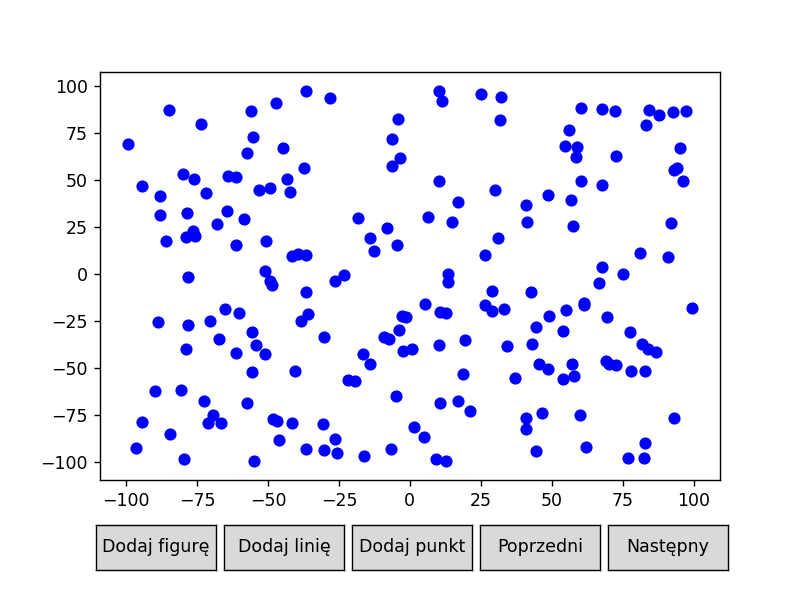

In [16]:
%matplotlib notebook
def setA(n=200,low=-100,high=100):
    array = []
    for i in range(n):
        array.append((np.random.uniform(low,high),np.random.uniform(low,high)))
    return array

arrayA = setA()
Plot(points = [PointsCollection(arrayA,color="blue")]).draw()

## Zbiór B

<IPython.core.display.Javascript object>


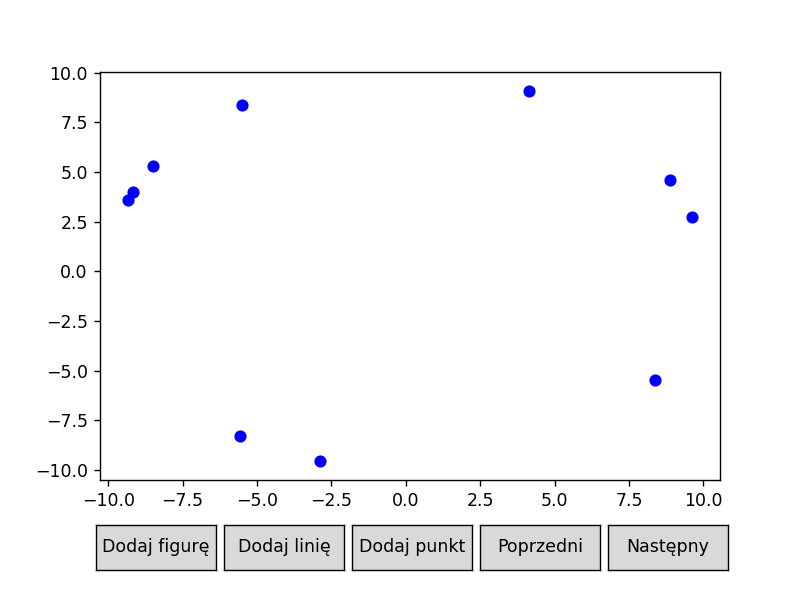

In [17]:
%matplotlib notebook
def setB(n=10,center=(0,0),radius=10):
    array = []
    for i in range(n):
        alpha = np.random.uniform(0,2*np.pi)
        array.append((center[0] + radius*np.cos(alpha),center[1] + radius*np.sin(alpha)))
    return array

arrayB = setB()
Plot(points = [PointsCollection(arrayB,color="blue")]).draw()

## Zbiór C

<IPython.core.display.Javascript object>


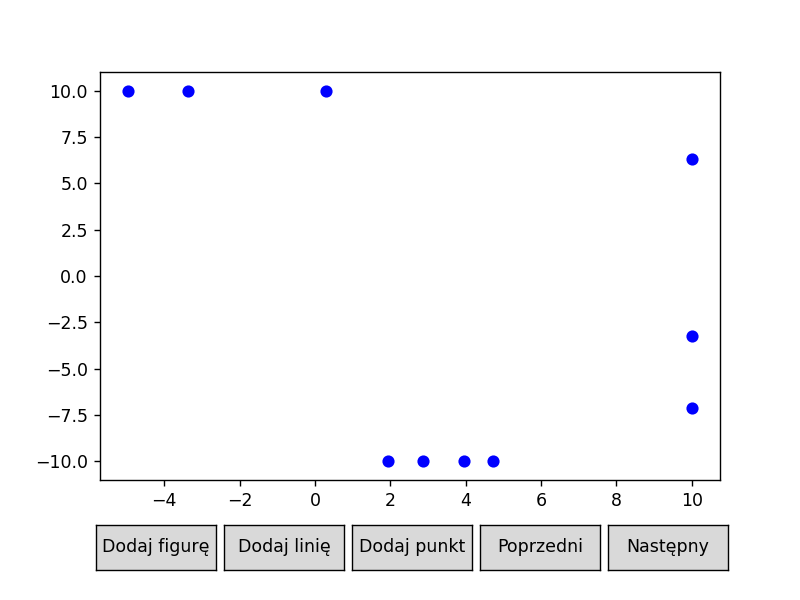

In [18]:
%matplotlib notebook
def setC(n=10,vertices=[(-10,-10),(10,10)]): # vertices = [(Xmin,Ymin),(Xmax,Ymax)] - leftLower i rightUpper
    array = []
    for i in range(n):
        randomizer = np.random.randint(2)
        oppositeSide = np.random.randint(2)
        if randomizer:  
            randomNumber = np.random.uniform(vertices[0][0],vertices[1][0]) # horizontal
            if oppositeSide:
                array.append((randomNumber,vertices[1][1])) # upper
            else:
                array.append((randomNumber,vertices[0][1])) # lower
        else:
            randomNumber = np.random.uniform(vertices[0][1],vertices[1][1])  # vertical
            if oppositeSide:
                array.append((vertices[1][0],randomNumber)) # right
            else:
                array.append((vertices[0][0],randomNumber)) # left
    return array

arrayC = setC()
Plot(points = [PointsCollection(arrayC,color="blue")]).draw()

## Zbiór D

<IPython.core.display.Javascript object>


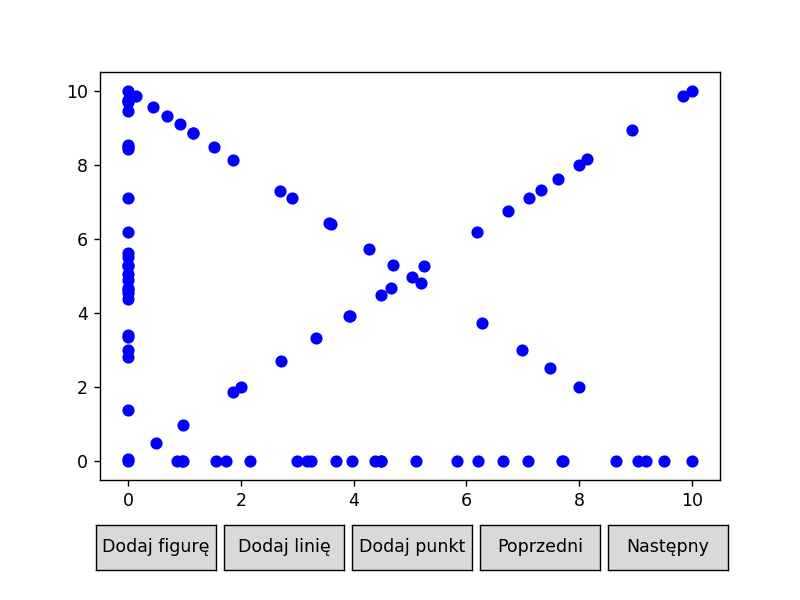

In [19]:
%matplotlib notebook
def setD(vertices=[(0,0),(10,0),(10,10),(0,10)],n=25,m=20):
    array = [vertices[0],vertices[1],vertices[2],vertices[3]]
    for i in range(n):
        randomNumber1 = np.random.uniform(vertices[0][0],vertices[1][0])
        randomNumber2 = np.random.uniform(vertices[0][1],vertices[3][1])
        array.append((randomNumber1,0))
        array.append((0,randomNumber2))
    for i in range(m):
        x = np.random.uniform(vertices[0][0],vertices[1][0])
        x2 = np.random.uniform(vertices[0][0],vertices[1][0])
        array.append((x,x))
        array.append((x2,-1*x2 + vertices[3][1]))
    return array

arrayD = setD()
Plot(points = [PointsCollection(arrayD,color="blue")]).draw()

# Wizualizacja algorytmów

## 1. Incremental Algorithm

### Zbiór A

In [ ]:
%matplotlib notebook
plotA_incremental_algorithm = plot_incremental_algorithm(arrayA)
plotA_incremental_algorithm.draw()

### Zbiór B

In [ ]:
%matplotlib notebook
plotB_incremental_algorithm = plot_incremental_algorithm(arrayB)
plotB_incremental_algorithm.draw()

### Zbiór C

In [ ]:
%matplotlib notebook
plotC_incremental_algorithm = plot_incremental_algorithm(arrayC)
plotC_incremental_algorithm.draw()

### Zbiór D

In [ ]:
%matplotlib notebook
plotD_incremental_algorithm = plot_incremental_algorithm(arrayD)
plotD_incremental_algorithm.draw()

## 2. Upper and lower hulls Algorithm

### Zbiór A

In [ ]:
%matplotlib notebook
plotA_upper_lower_algorithm = plot_upper_lower_algorithm(arrayA)
plotA_upper_lower_algorithm.draw()

### Zbiór B

In [ ]:
%matplotlib notebook
plotB_upper_lower_algorithm = plot_upper_lower_algorithm(arrayB)
plotB_upper_lower_algorithm.draw()

### Zbiór C

In [ ]:
%matplotlib notebook
plotC_upper_lower_algorithm = plot_upper_lower_algorithm(arrayC)
plotC_upper_lower_algorithm.draw()

### Zbiór D

In [ ]:
%matplotlib notebook
plotD_upper_lower_algorithm = plot_upper_lower_algorithm(arrayD)
plotD_upper_lower_algorithm.draw()

## 3. Graham Algorithm

### Zbiór A

In [ ]:
%matplotlib notebook
plotA_graham_algorithm = plot_graham_algorithm(arrayA)
plotA_graham_algorithm.draw()

### Zbiór B

In [ ]:
%matplotlib notebook
plotB_graham_algorithm = plot_graham_algorithm(arrayB)
plotB_graham_algorithm.draw()

### Zbiór C

In [ ]:
%matplotlib notebook
plotC_graham_algorithm = plot_graham_algorithm(arrayC)
plotC_graham_algorithm.draw()

### Zbiór D

In [ ]:
%matplotlib notebook
plotD_graham_algorithm = plot_graham_algorithm(arrayD)
plotD_graham_algorithm.draw()

## 4. Jarvis Algorithm

### Zbiór A

In [ ]:
%matplotlib notebook
plotA_jarvis_algorithm = plot_jarvis_algorithm(arrayA)
plotA_jarvis_algorithm.draw()

### Zbiór B

In [ ]:
%matplotlib notebook
plotB_jarvis_algorithm = plot_jarvis_algorithm(arrayB)
plotB_jarvis_algorithm.draw()

### Zbiór C

In [ ]:
%matplotlib notebook
plotC_jarvis_algorithm = plot_jarvis_algorithm(arrayC)
plotC_jarvis_algorithm.draw()

### Zbiór D

In [ ]:
%matplotlib notebook
plotD_jarvis_algorithm = plot_jarvis_algorithm(arrayD)
plotD_jarvis_algorithm.draw()

## 5. Divide and Conquer Algorithm

### Zbiór A

In [ ]:
%matplotlib notebook
plotA_divide_and_conquer_algorithm = plot_divide_and_conquer_algorithm(arrayA, 5)
plotA_divide_and_conquer_algorithm.draw()

### Zbiór B

In [ ]:
%matplotlib notebook
plotB_divide_and_conquer_algorithm = plot_divide_and_conquer_algorithm(arrayB, 5)
plotB_divide_and_conquer_algorithm.draw()

### Zbiór C

In [ ]:
%matplotlib notebook
plotC_divide_and_conquer_algorithm = plot_divide_and_conquer_algorithm(arrayC, 5)
plotC_divide_and_conquer_algorithm.draw()

### Zbiór D

In [ ]:
%matplotlib notebook
plotD_divide_and_conquer_algorithm = plot_divide_and_conquer_algorithm(arrayD, 5)
plotD_divide_and_conquer_algorithm.draw()

## 6. QuickHull Algorithm

### Zbiór A

In [ ]:
%matplotlib notebook
plotA_quickhull = plot_quickhull(arrayA)
plotA_quickhull.draw()

### Zbiór B

In [ ]:
%matplotlib notebook
plotB_quickhull = plot_quickhull(arrayB)
plotB_quickhull.draw()

### Zbiór C

In [ ]:
%matplotlib notebook
plotC_quickhull = plot_quickhull(arrayC)
plotC_quickhull.draw()

### Zbiór D

In [ ]:
%matplotlib notebook
plotD_quickhull = plot_quickhull(arrayD)
plotD_quickhull.draw()

## 7. Chan's Algorithm

### Zbiór A

In [ ]:
%matplotlib notebook
plotA_chan = plot_chan_algorithm(arrayA)
plotA_chan.draw()

### Zbiór B

In [ ]:
%matplotlib notebook
plotB_chan = plot_chan_algorithm(arrayB)
plotB_chan.draw()

### Zbiór C

In [ ]:
%matplotlib notebook
plotC_chan = plot_chan_algorithm(arrayC)
plotC_chan.draw()

### Zbiór D

In [ ]:
%matplotlib notebook
plotD_chan = plot_chan_algorithm(arrayD)
plotD_chan.draw()

In [40]:
A50 = setA(50)
A100 = setA(100)
A200 = setA(200)
A500 = setA(500)
A1000 = setA(1000)
A10000 = setA(10000)
B50 = setB(50)
B100 = setB(100)
B200 = setB(200)
B500 = setB(500)
B1000 = setB(1000)
B10000 = setB(10000)
C50 = setC(50)
C100 = setC(100)
C200 = setC(200)
C500 = setC(500)
C1000 = setC(1000)
C10000 = setC(10000)
D50 = setD(n = 50)
D100 = setD(n = 100)
D200 = setD(n = 200)
D500 = setD(n = 500)
D1000 = setD(n = 1000)
D10000 = setD(n = 10000)



## Czas Przyrostowy

In [41]:
import time

start = time.time()
incremental_algorithm(A50)
end = time.time() - start
print("A 50 : ",  end)

start = time.time()
incremental_algorithm(A100)
end = time.time() - start
print("A 100 : ",  end)

start = time.time()
incremental_algorithm(A200)
end = time.time() - start
print("A  200 : ",  end)

start = time.time()
incremental_algorithm(A500)
end = time.time() - start
print("A 500 : ",  end)

start = time.time()
incremental_algorithm(A1000)
end = time.time() - start
print("A  1000 : ",  end)


start = time.time()
incremental_algorithm(B50)
end = time.time() - start
print("B 50 : ",  end)

start = time.time()
incremental_algorithm(B100)
end = time.time() - start
print("B 100 : ",  end)

start = time.time()
incremental_algorithm(B200)
end = time.time() - start
print("B 200 : ",  end)

start = time.time()
incremental_algorithm(B500)
end = time.time() - start
print("B 500 : ",  end)

start = time.time()
incremental_algorithm(B1000)
end = time.time() - start
print("B 1000 : ",  end)

start = time.time()
incremental_algorithm(C50)
end = time.time() - start
print("C 50 : ",  end)

start = time.time()
incremental_algorithm(C100)
end = time.time() - start
print("C 100 : ",  end)

start = time.time()
incremental_algorithm(C200)
end = time.time() - start
print("C 200 : ",  end)

start = time.time()
incremental_algorithm(C500)
end = time.time() - start
print("C 500 : ",  end)

start = time.time()
incremental_algorithm(C1000)
end = time.time() - start
print("C 1000 : ",  end)

start = time.time()
incremental_algorithm(D50)
end = time.time() - start
print("D 50 : ",  end)

start = time.time()
incremental_algorithm(D100)
end = time.time() - start
print("D 100 : ",  end)

start = time.time()
incremental_algorithm(D200)
end = time.time() - start
print("D 200 : ",  end)

start = time.time()
incremental_algorithm(D500)
end = time.time() - start
print("D 500 : ",  end)

start = time.time()
incremental_algorithm(D1000)
end = time.time() - start
print("D 1000 : ",  end)



A 50 :  0.0010423660278320312
A 100 :  0.001983165740966797
A  200 :  0.0050008296966552734
A 500 :  0.012555360794067383
A  1000 :  0.03696489334106445
B 50 :  0.014001846313476562
B 100 :  0.03400254249572754
B 200 :  0.1409614086151123
B 500 :  0.8101632595062256
B 1000 :  2.996202230453491
C 50 :  0.000965118408203125
C 100 :  0.0019943714141845703
C 200 :  0.0060367584228515625
C 500 :  0.011966705322265625
C 1000 :  0.025002241134643555
D 50 :  0.0010006427764892578
D 100 :  0.004000186920166016
D 200 :  0.00799560546875
D 500 :  0.02002239227294922
D 1000 :  0.027994871139526367


## Czas Górna Dolna

In [42]:
start = time.time()
upper_lower_algorithm(A50)
end = time.time() - start
print("A 50 : ",  end)

start = time.time()
upper_lower_algorithm(A100)
end = time.time() - start
print("A 100 : ",  end)

start = time.time()
upper_lower_algorithm(A200)
end = time.time() - start
print("A  200 : ",  end)

start = time.time()
upper_lower_algorithm(A500)
end = time.time() - start
print("A 500 : ",  end)

start = time.time()
upper_lower_algorithm(A1000)
end = time.time() - start
print("A  1000 : ",  end)


start = time.time()
upper_lower_algorithm(B50)
end = time.time() - start
print("B 50 : ",  end)

start = time.time()
upper_lower_algorithm(B100)
end = time.time() - start
print("B 100 : ",  end)

start = time.time()
upper_lower_algorithm(B200)
end = time.time() - start
print("B 200 : ",  end)

start = time.time()
upper_lower_algorithm(B500)
end = time.time() - start
print("B 500 : ",  end)

start = time.time()
upper_lower_algorithm(B1000)
end = time.time() - start
print("B 1000 : ",  end)

start = time.time()
upper_lower_algorithm(C50)
end = time.time() - start
print("C 50 : ",  end)

start = time.time()
upper_lower_algorithm(C100)
end = time.time() - start
print("C 100 : ",  end)

start = time.time()
upper_lower_algorithm(C200)
end = time.time() - start
print("C 200 : ",  end)

start = time.time()
upper_lower_algorithm(C500)
end = time.time() - start
print("C 500 : ",  end)

start = time.time()
upper_lower_algorithm(C1000)
end = time.time() - start
print("C 1000 : ",  end)

start = time.time()
upper_lower_algorithm(D50)
end = time.time() - start
print("D 50 : ",  end)

start = time.time()
upper_lower_algorithm(D100)
end = time.time() - start
print("D 100 : ",  end)

start = time.time()
upper_lower_algorithm(D200)
end = time.time() - start
print("D 200 : ",  end)

start = time.time()
upper_lower_algorithm(D500)
end = time.time() - start
print("D 500 : ",  end)

start = time.time()
upper_lower_algorithm(D1000)
end = time.time() - start
print("D 1000 : ",  end)


A 50 :  0.0009577274322509766
A 100 :  0.0009984970092773438
A  200 :  0.001999378204345703
A 500 :  0.003031015396118164
A  1000 :  0.007999658584594727
B 50 :  0.0009987354278564453
B 100 :  0.00099945068359375
B 200 :  0.0029098987579345703
B 500 :  0.006067752838134766
B 1000 :  0.010996341705322266
C 50 :  0.0
C 100 :  0.003003358840942383
C 200 :  0.003029346466064453
C 500 :  0.004967451095581055
C 1000 :  0.004999876022338867
D 50 :  0.0030012130737304688
D 100 :  0.0030286312103271484
D 200 :  0.00397038459777832
D 500 :  0.009016990661621094
D 1000 :  0.011978864669799805


## Czas Graham

In [43]:
start = time.time()
graham_algorithm(A50)
end = time.time() - start
print("A 50 : ",  end)

start = time.time()
graham_algorithm(A100)
end = time.time() - start
print("A 100 : ",  end)

start = time.time()
graham_algorithm(A200)
end = time.time() - start
print("A  200 : ",  end)

start = time.time()
graham_algorithm(A500)
end = time.time() - start
print("A 500 : ",  end)

start = time.time()
graham_algorithm(A1000)
end = time.time() - start
print("A  1000 : ",  end)


start = time.time()
graham_algorithm(B50)
end = time.time() - start
print("B 50 : ",  end)

start = time.time()
graham_algorithm(B100)
end = time.time() - start
print("B 100 : ",  end)

start = time.time()
graham_algorithm(B200)
end = time.time() - start
print("B 200 : ",  end)

start = time.time()
graham_algorithm(B500)
end = time.time() - start
print("B 500 : ",  end)

start = time.time()
graham_algorithm(B1000)
end = time.time() - start
print("B 1000 : ",  end)

start = time.time()
graham_algorithm(C50)
end = time.time() - start
print("C 50 : ",  end)

start = time.time()
graham_algorithm(C100)
end = time.time() - start
print("C 100 : ",  end)

start = time.time()
graham_algorithm(C200)
end = time.time() - start
print("C 200 : ",  end)

start = time.time()
graham_algorithm(C500)
end = time.time() - start
print("C 500 : ",  end)

start = time.time()
graham_algorithm(C1000)
end = time.time() - start
print("C 1000 : ",  end)

start = time.time()
graham_algorithm(D50)
end = time.time() - start
print("D 50 : ",  end)

start = time.time()
graham_algorithm(D100)
end = time.time() - start
print("D 100 : ",  end)

start = time.time()
graham_algorithm(D200)
end = time.time() - start
print("D 200 : ",  end)

start = time.time()
graham_algorithm(D500)
end = time.time() - start
print("D 500 : ",  end)

start = time.time()
graham_algorithm(D1000)
end = time.time() - start
print("D 1000 : ",  end)

A 50 :  0.0009984970092773438
A 100 :  0.0009999275207519531
A  200 :  0.0019989013671875
A 500 :  0.0070037841796875
A  1000 :  0.01399850845336914
B 50 :  0.0019214153289794922
B 100 :  0.0020248889923095703
B 200 :  0.003966808319091797
B 500 :  0.018999814987182617
B 1000 :  0.03499937057495117
C 50 :  0.0
C 100 :  0.0009982585906982422
C 200 :  0.0040035247802734375
C 500 :  0.006037235260009766
C 1000 :  0.014989852905273438
D 50 :  0.0010349750518798828
D 100 :  0.001965045928955078
D 200 :  0.008032798767089844
D 500 :  0.011988639831542969
D 1000 :  0.023001670837402344


## Czas Jarvis

In [44]:
start = time.time()
jarvis_algorithm(A50)
end = time.time() - start
print("A 50 : ",  end)

start = time.time()
jarvis_algorithm(A100)
end = time.time() - start
print("A 100 : ",  end)

start = time.time()
jarvis_algorithm(A200)
end = time.time() - start
print("A  200 : ",  end)

start = time.time()
jarvis_algorithm(A500)
end = time.time() - start
print("A 500 : ",  end)

start = time.time()
jarvis_algorithm(A1000)
end = time.time() - start
print("A  1000 : ",  end)


start = time.time()
jarvis_algorithm(B50)
end = time.time() - start
print("B 50 : ",  end)

start = time.time()
jarvis_algorithm(B100)
end = time.time() - start
print("B 100 : ",  end)

start = time.time()
jarvis_algorithm(B200)
end = time.time() - start
print("B 200 : ",  end)

start = time.time()
jarvis_algorithm(B500)
end = time.time() - start
print("B 500 : ",  end)

start = time.time()
jarvis_algorithm(B1000)
end = time.time() - start
print("B 1000 : ",  end)

start = time.time()
jarvis_algorithm(C50)
end = time.time() - start
print("C 50 : ",  end)

start = time.time()
jarvis_algorithm(C100)
end = time.time() - start
print("C 100 : ",  end)

start = time.time()
jarvis_algorithm(C200)
end = time.time() - start
print("C 200 : ",  end)

start = time.time()
jarvis_algorithm(C500)
end = time.time() - start
print("C 500 : ",  end)

start = time.time()
jarvis_algorithm(C1000)
end = time.time() - start
print("C 1000 : ",  end)

start = time.time()
jarvis_algorithm(D50)
end = time.time() - start
print("D 50 : ",  end)

start = time.time()
jarvis_algorithm(D100)
end = time.time() - start
print("D 100 : ",  end)

start = time.time()
jarvis_algorithm(D200)
end = time.time() - start
print("D 200 : ",  end)

start = time.time()
jarvis_algorithm(D500)
end = time.time() - start
print("D 500 : ",  end)

start = time.time()
jarvis_algorithm(D1000)
end = time.time() - start
print("D 1000 : ",  end)

A 50 :  0.000997781753540039
A 100 :  0.00600123405456543
A  200 :  0.003991842269897461
A 500 :  0.006000518798828125
A  1000 :  0.023964405059814453
B 50 :  0.00905919075012207
B 100 :  0.03898978233337402
B 200 :  0.11899876594543457
B 500 :  0.7615091800689697
B 1000 :  3.015076160430908
C 50 :  0.0010037422180175781
C 100 :  0.000993490219116211
C 200 :  0.0019989013671875
C 500 :  0.005002260208129883
C 1000 :  0.017000913619995117
D 50 :  0.001970529556274414
D 100 :  0.0029985904693603516
D 200 :  0.0030002593994140625
D 500 :  0.0069942474365234375
D 1000 :  0.015975236892700195


## Czas Dziel i rządź

In [45]:
start = time.time()
divide_and_conquer_algorithm(A50, 5)
end = time.time() - start
print("A 50 : ",  end)

start = time.time()
divide_and_conquer_algorithm(A100, 5)
end = time.time() - start
print("A 100 : ",  end)

start = time.time()
divide_and_conquer_algorithm(A200, 5)
end = time.time() - start
print("A  200 : ",  end)

start = time.time()
divide_and_conquer_algorithm(A500,5)
end = time.time() - start
print("A 500 : ",  end)

start = time.time()
divide_and_conquer_algorithm(A1000,5)
end = time.time() - start
print("A  1000 : ",  end)


start = time.time()
divide_and_conquer_algorithm(B50,5)
end = time.time() - start
print("B 50 : ",  end)

start = time.time()
divide_and_conquer_algorithm(B100,5)
end = time.time() - start
print("B 100 : ",  end)

start = time.time()
divide_and_conquer_algorithm(B200,5)
end = time.time() - start
print("B 200 : ",  end)

start = time.time()
divide_and_conquer_algorithm(B500,5)
end = time.time() - start
print("B 500 : ",  end)

start = time.time()
divide_and_conquer_algorithm(B1000,5)
end = time.time() - start
print("B 1000 : ",  end)

start = time.time()
divide_and_conquer_algorithm(C50,5)
end = time.time() - start
print("C 50 : ",  end)

start = time.time()
divide_and_conquer_algorithm(C100,5)
end = time.time() - start
print("C 100 : ",  end)

start = time.time()
divide_and_conquer_algorithm(C200,5)
end = time.time() - start
print("C 200 : ",  end)

start = time.time()
divide_and_conquer_algorithm(C500,5)
end = time.time() - start
print("C 500 : ",  end)

start = time.time()
divide_and_conquer_algorithm(C1000,5)
end = time.time() - start
print("C 1000 : ",  end)

start = time.time()
divide_and_conquer_algorithm(D50,5)
end = time.time() - start
print("D 50 : ",  end)

start = time.time()
divide_and_conquer_algorithm(D100,5)
end = time.time() - start
print("D 100 : ",  end)

start = time.time()
divide_and_conquer_algorithm(D200,5)
end = time.time() - start
print("D 200 : ",  end)

start = time.time()
divide_and_conquer_algorithm(D500,5)
end = time.time() - start
print("D 500 : ",  end)

start = time.time()
divide_and_conquer_algorithm(D1000,5)
end = time.time() - start
print("D 1000 : ",  end)

A 50 :  0.0010006427764892578
A 100 :  0.001994609832763672
A  200 :  0.0029866695404052734
A 500 :  0.010998964309692383
A  1000 :  0.025997161865234375
B 50 :  0.003987312316894531
B 100 :  0.003999233245849609
B 200 :  0.017999649047851562
B 500 :  0.03599667549133301
B 1000 :  0.0720052719116211
C 50 :  0.0009963512420654297
C 100 :  0.00099945068359375
C 200 :  0.002000570297241211
C 500 :  0.004998207092285156
C 1000 :  0.014000654220581055
D 50 :  0.0020008087158203125
D 100 :  0.005997180938720703
D 200 :  0.005998134613037109
D 500 :  0.012000083923339844
D 1000 :  0.02400064468383789


## Czas QuickHull

In [46]:
start = time.time()
quickhull(A50.copy())
end = time.time() - start
print("A 50 : ",  end)

start = time.time()
quickhull(A100.copy())
end = time.time() - start
print("A 100 : ",  end)

start = time.time()
quickhull(A200.copy())
end = time.time() - start
print("A  200 : ",  end)

start = time.time()
quickhull(A500)
end = time.time() - start
print("A 500 : ",  end)

start = time.time()
quickhull(A1000)
end = time.time() - start
print("A  1000 : ",  end)


start = time.time()
quickhull(B50)
end = time.time() - start
print("B 50 : ",  end)

start = time.time()
quickhull(B100)
end = time.time() - start
print("B 100 : ",  end)

start = time.time()
quickhull(B200)
end = time.time() - start
print("B 200 : ",  end)

start = time.time()
quickhull(B500)
end = time.time() - start
print("B 500 : ",  end)

start = time.time()
quickhull(B1000)
end = time.time() - start
print("B 1000 : ",  end)

start = time.time()
quickhull(C50)
end = time.time() - start
print("C 50 : ",  end)

start = time.time()
quickhull(C100)
end = time.time() - start
print("C 100 : ",  end)

start = time.time()
quickhull(C200)
end = time.time() - start
print("C 200 : ",  end)

start = time.time()
quickhull(C500)
end = time.time() - start
print("C 500 : ",  end)

start = time.time()
quickhull(C1000)
end = time.time() - start
print("C 1000 : ",  end)

start = time.time()
quickhull(D50)
end = time.time() - start
print("D 50 : ",  end)

start = time.time()
quickhull(D100)
end = time.time() - start
print("D 100 : ",  end)

start = time.time()
quickhull(D200)
end = time.time() - start
print("D 200 : ",  end)

start = time.time()
quickhull(D500)
end = time.time() - start
print("D 500 : ",  end)

start = time.time()
quickhull(D1000)
end = time.time() - start
print("D 1000 : ",  end)

A 50 :  0.0010013580322265625
A 100 :  0.0009963512420654297
A  200 :  0.0020017623901367188
A 500 :  0.007075071334838867
A  1000 :  0.007981061935424805
B 50 :  0.0030014514923095703
B 100 :  0.004036426544189453
B 200 :  0.011960268020629883
B 500 :  0.039032697677612305
B 1000 :  0.0800018310546875
C 50 :  0.0
C 100 :  0.0009655952453613281
C 200 :  0.0009644031524658203
C 500 :  0.0059833526611328125
C 1000 :  0.009030342102050781
D 50 :  0.0
D 100 :  0.0039675235748291016
D 200 :  0.0030319690704345703
D 500 :  0.005967378616333008
D 1000 :  0.014999628067016602


## Czas Chan

In [47]:
start = time.time()
chan_algorithm(A50.copy())
end = time.time() - start
print("A 50 : ",  end)

start = time.time()
chan_algorithm(A100.copy())
end = time.time() - start
print("A 100 : ",  end)

start = time.time()
chan_algorithm(A200.copy())
end = time.time() - start
print("A  200 : ",  end)

start = time.time()
chan_algorithm(A500)
end = time.time() - start
print("A 500 : ",  end)

start = time.time()
chan_algorithm(A1000)
end = time.time() - start
print("A  1000 : ",  end)


start = time.time()
chan_algorithm(B50)
end = time.time() - start
print("B 50 : ",  end)

start = time.time()
chan_algorithm(B100)
end = time.time() - start
print("B 100 : ",  end)

start = time.time()
chan_algorithm(B200)
end = time.time() - start
print("B 200 : ",  end)

start = time.time()
chan_algorithm(B500)
end = time.time() - start
print("B 500 : ",  end)

start = time.time()
chan_algorithm(B1000)
end = time.time() - start
print("B 1000 : ",  end)

start = time.time()
chan_algorithm(C50)
end = time.time() - start
print("C 50 : ",  end)

start = time.time()
chan_algorithm(C100)
end = time.time() - start
print("C 100 : ",  end)

start = time.time()
chan_algorithm(C200)
end = time.time() - start
print("C 200 : ",  end)

start = time.time()
chan_algorithm(C500)
end = time.time() - start
print("C 500 : ",  end)

start = time.time()
chan_algorithm(C1000)
end = time.time() - start
print("C 1000 : ",  end)

start = time.time()
chan_algorithm(D50)
end = time.time() - start
print("D 50 : ",  end)

start = time.time()
chan_algorithm(D100)
end = time.time() - start
print("D 100 : ",  end)

start = time.time()
chan_algorithm(D200)
end = time.time() - start
print("D 200 : ",  end)

start = time.time()
chan_algorithm(D500)
end = time.time() - start
print("D 500 : ",  end)

start = time.time()
chan_algorithm(D1000)
end = time.time() - start
print("D 1000 : ",  end)

A 50 :  0.001003265380859375
A 100 :  0.002996683120727539
A  200 :  0.0035860538482666016
A 500 :  0.012028694152832031
A  1000 :  0.04196763038635254
B 50 :  0.01305532455444336
B 100 :  0.05053520202636719
B 200 :  0.17508339881896973
B 500 :  1.277463436126709
B 1000 :  4.351489067077637
C 50 :  0.002000570297241211
C 100 :  0.00496983528137207
C 200 :  0.006997823715209961
C 500 :  0.01903843879699707
C 1000 :  0.03299880027770996
D 50 :  0.006032228469848633
D 100 :  0.0060002803802490234
D 200 :  0.014011383056640625
D 500 :  0.03198885917663574
D 1000 :  0.06396722793579102
